In [4]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

In [5]:
# default_exp dr

# Dimensionality reduction

> This notebook gets the latent features from a multivariate time series 
given by an autoencoder and uses them as input for a dimensionality reduction algorithm

In [6]:
# export
import umap
import pandas as pd
import numpy as np

In [7]:
# hide
import matplotlib.pyplot as plt
from pacmel_mining_use_case.load import fmultiTSloader
import wandb
from yaml import load, FullLoader
from tensorflow.keras.models import load_model
from fastcore.utils import Path
from fastcore import test

This model needs to restore the model fitted in the notebook `01_DCAE`, as well as the data and configuration

In [8]:
# hide
run_dr = wandb.init(project="timecluster-extension", 
                    allow_val_change=True, 
                    job_type='dimensionality_reduction', 
                    resume="3m7bo8r0")
config_dr = wandb.config # Object for storing hyperparameters

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Streaming file created twice in same run: /home/jovyan/work/nbs/wandb/run-20200413_161126-3m7bo8r0/wandb-events.jsonl
Streaming file created twice in same run: /home/jovyan/work/nbs/wandb/run-20200413_161126-3m7bo8r0/wandb-history.jsonl


Restore a DCAE model and its associated configuration

In [9]:
dcae_run_path = 'vrodriguezf/timecluster-extension/orelcv79'
dcae_model = load_model(wandb.restore('model-best.h5', replace=True, run_path=dcae_run_path).name)
with open(wandb.restore('config.yaml', replace=True, run_path=dcae_run_path).name) as file:
    dcae_config = load(file, FullLoader)

Restore the dataset artifact used for creating the DCAE. TODO: How to get the input artifact from
the specific run from which we are restoring the configuration, without having to manually log
the dataset artifact name in the configuration object?

In [10]:
ds_artifact_type = dcae_config.get('ds_artifact_type_name').get('value').split("/")[0]
ds_artifact_name = dcae_config.get('ds_artifact_type_name').get('value').split("/")[1]
ds_artifact_digest = dcae_config.get('ds_artifact_digest').get('value')
ds_artifact = run_dr.use_artifact(type=ds_artifact_type, 
                                  name=ds_artifact_digest)
datadir = Path(ds_artifact.download())

In [11]:
df, df_slices, dcae_input = fmultiTSloader(df_paths=datadir.ls(), 
                                           w=dcae_config.get('w').get('value'),
                                           stride=dcae_config.get('stride').get('value'))

../pacmel_mining_use_case/load.py:72: DtypeWarning:

Columns (18,19,20,21,22,23,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Getting the latent variables from the trained model

Once the DCAE model is trained, we are interested in the information contained in the **Dense** layer (also called *bottleneck*)for each slice of data. To do that, we have to call the `predict` function on an intermediate model that gets the output of the intermediate layer.

In [12]:
# export dcae
from tensorflow.keras.models import Model 
def get_latent_features(dcae, input_data, bottleneck_ln='latent_features'):
    "Get the activations of the bottleneck layer within the fitted autoencoder `dcae` (a Keras model) \
    for the input data `input_data` (a tensor). The name of the bottleneck layer is given in `bottleneck_ln"
    layer_latent_output = dcae.get_layer(bottleneck_ln).output
    intermediate_model = Model(inputs=dcae.input, outputs=layer_latent_output)
    intermediate_prediction = intermediate_model.predict(input_data)
    return intermediate_prediction

In [13]:
intermediate_prediction = get_latent_features(dcae_model, dcae_input, 'latent_features')

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent features given by the DCAE.

The hyperparameters of UMAP are given randomly here. In the future, an app will be created to play with them.

In [14]:
config_dr.update(allow_val_change=True, params= {
    'n_neighbors' : 15,
    'min_dist' : 0.2,
    'metric' : 'euclidean'
})

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Finall, we gather all this functionality into a function for future use

In [15]:
# export
import warnings
from numba.errors import NumbaPerformanceWarning
def fget_UMAP_embeddings(input_data, **kwargs):
    "Compute the embeddings of `input_data` using UMAP, with a configuration contained in `**kwargs`. \
    Returns also information of the reducer."
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning) # silence NumbaPerformanceWarning
    reducer = umap.UMAP(**kwargs)
    reducer.fit(input_data)
    embeddings = reducer.transform(input_data)
    return (embeddings, reducer)

In [16]:
embeddings, reducer = fget_UMAP_embeddings(intermediate_prediction, **config_dr)
embeddings.shape

/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 7 separate connected components using meta-embedding (experimental)



(8638, 2)

In [17]:
test.equals(embeddings.shape, (intermediate_prediction.shape[0], reducer.n_components))

True

In [18]:
# Test if the reducer contains the items of the configuration object
test.equals(all(item in reducer.get_params().items() for item in dict(config_dr).items()), True)

True

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [19]:
# export 
def fplot_embeddings(embeddings):
    "Plot 2D embeddings thorugh a connected scatter plot"
    df_embeddings = pd.DataFrame(embeddings, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
    return ax

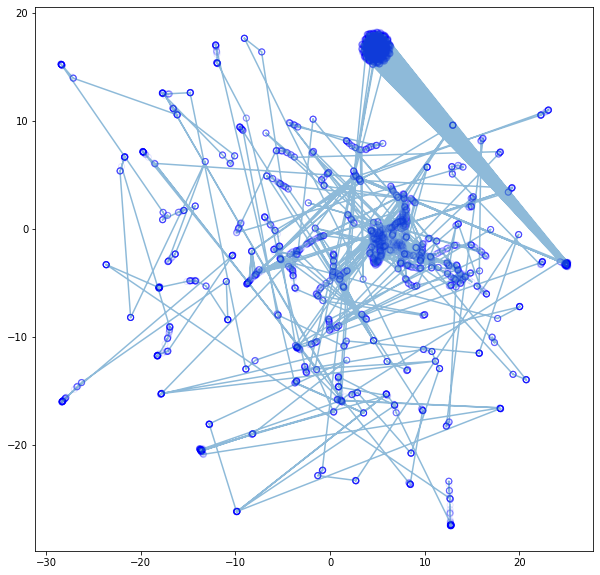

In [20]:
embeddings_plot = fplot_embeddings(embeddings)

Log this plot as part of the current wandb run

In [21]:
# hide
run_dr.log({'embeddings_plot': embeddings_plot})

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/opt/conda/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



We also log the table with the contents of the embeddings, along with the time interval associated to each embedding.

In [22]:
# export load
def fget_time_interval_of_window(w_index, ref_ts, w_size, stride=1):
    "Returns the time interval of the window `w_index` as a datetime tuple (start, end). \
    A reference timestamp `ts`, a window size `w_size` and a stride value `stride` must be \
    provided too."
    return None

In [23]:
# indices = np.arange(0, len(embeddings)-1, 1)
# start_time = np.array([x.timestamp.values[0] for x in df_slices])
# end_time = np.array([x.timestamp[-1] for x in df_slices])

In [24]:
indices = np.arange(0, len(embeddings), 1)
run_dr.log({
    'embeddings_table (first 1000 rows)': wandb.Table(columns=['index', 'x1', 'x2', 'start', 'end'], 
                                    data=list(np.column_stack((indices, 
                                                               embeddings))))
})

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Let's log also the data of each time window, using a different log step (parameter in wandb) for each index of the object `df_slices`

In [79]:
# export visualization
import plotly.express as px
def fplot_multiTS_from_df(df, cname_ts='timestamp', ncol=3, **plot_args):
    "Returns a plotly object with the multivariate time series resulting from \
    a pandas dataframe `df`. The timestamp is given by \
    the column `cname_ts`. The argument `ncol` defines the number of columns in \
    the matrix plots created. The argument `plot_args` is passed to the call to \
    `Plotly_express.line`."
    assert cname_ts in df.columns
    df_long = pd.melt(df, id_vars=[cname_ts], 
                      value_vars=df.drop(cname_ts, axis=1).columns)
    g = px.line(data_frame=df_long, 
                x=cname_ts, 
                y='value', 
                facet_col='variable',
                facet_col_wrap=ncol, **plot_args)
    return g

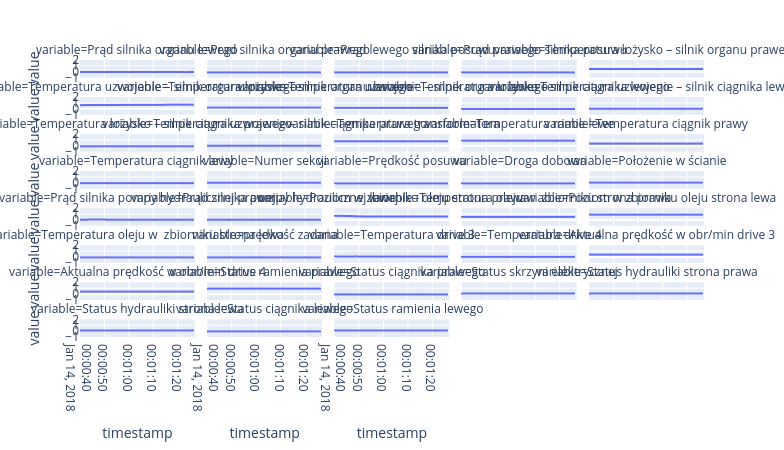

In [80]:
asd = fplot_multiTS_from_df(df_slices[2], ncol=5)
asd.show()

In [72]:
run_dr.log({'Sample plot': asd})

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for (i, df_slice) in enumerate(df_slices):
    run_dr.log({f'Data for the #{i} time window': fplot_multiTS_from_df(df_slice, ncol=5)}, 
               step=i)

wandb: WARNING Adding to old History rows isn't currently supported.  Step 0 < 25; dropping {'Data for the #0 time window': Figure({
wandb: WARNING     'data': [{'hovertemplate': ('variable=Prąd silnika organu l' ... '}<br>value=%{y}<extra></extra>'),
wandb: WARNING               'legendgroup': '',
wandb: WARNING               'line': {'color': '#636efa', 'dash': 'solid'},
wandb: WARNING               'mode': 'lines',
wandb: WARNING               'name': '',
wandb: WARNING               'showlegend': False,
wandb: WARNING               'type': 'scattergl',
wandb: WARNING               'x': array([datetime.datetime(2018, 1, 14, 0, 0),
wandb: WARNING                           datetime.datetime(2018, 1, 14, 0, 0, 1),
wandb: WARNING                           datetime.datetime(2018, 1, 14, 0, 0, 2),
wandb: WARNING                           datetime.datetime(2018, 1, 14, 0, 0, 3),
wandb: WARNING                           datetime.datetime(2018, 1, 14, 0, 0, 4),
wandb: WARNING                

In [ ]:
run_dr.log({'Sample image': wandb.Image('/home/jovyan/work/img/tmp_plot.png')})

# TODO 

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [ ]:
selected_indices = None
selected_points = None

def onpick(event):
    global selected_points
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    global selected_indices
    selected_indices = event.ind
    selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
    print('onpick points (first):', selected_points[0])

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()
fig.tight_layout()
fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function

In [ ]:
# export
def 

In [ ]:
dfs = df_slices[0]


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [ ]:
selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
selected_window

### Visualizing all the variables in the time window (default)

In [ ]:
%matplotlib inline
g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [ ]:
# export
def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
    "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
    `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
    x = dcae.get_layer(lat_ln).output
    x = Dense(units=embeddings.shape[1], activation='linear')(x)
    surrogate_model = Model(dcae.input, x)
    l_nms = [layer.name for layer in surrogate_model.layers]
    layer_idx = l_nms.index(lat_ln)
    # The layers that are already trained from the autoencoder must be `frozen`
    for layer in surrogate_model.layers[:layer_idx]:
        layer.trainable = False
    return surrogate_model

In [ ]:
sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [ ]:
test.equals(sm.input.shape, m.input.shape)
test.equals(sm.output.shape[1], embeddings.shape[1])
l_nms = [layer.name for layer in sm.layers]
layer_idx = l_nms.index('latent_features')
test.all_equal([layer.trainable for layer in sm.layers], \
               np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [ ]:
loss = 'mean_squared_error'
opt = 'adam'
bs = 100
epochs = 10
val = .2

In [ ]:
sm.output_shape

In [ ]:
input_data.shape

In [ ]:
embeddings.shape

sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [ ]:
import innvestigate

In [ ]:
analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [ ]:
asd= innvestigate.create_analyzer("gradient", m)

In [ ]:
from keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.shape

In [ ]:
input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [ ]:
import shap

In [ ]:
background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
e = shap.DeepExplainer(intermediate_model, background)

In [ ]:
shap_values = e.shap_values(input_data[0:4])

In [ ]:
shap_values[0][0]